# AM216 Final Project: Neuroscience on Reinforcement Learning Agents

## Introduction
Neuroscience is making great technological strides, allowing ever more high resolution investigations into how the brain works. The latest optical and electrophysiological tools allow for the simultaneous recording of several thousand neurons in awake and behaving animals; other techniques, such expansion microscopy, allow scalable tracing of synaptic connectivity. In short, modern neuroscience has no shortage of data.

But let us consider a thought experiment: assume that we could record the activity from every neuron in the brain, and had access to the full connectome. Furthermore, assume we know both the learning rule employed by the brain, every experience it has ever had, and had complete control over the environment. In these conditions, what could we say about how the brain processes information and turns sensory stimuli into behaviour?

For this project, I explore this question in the context of deep neural network based reinforcement learning agents performing a task in a simple grid world environment. 

## Reinforcement Learning Model
A deep neural network based reinforcement learning agent was trained to achieve high reward in a simple grid world environment. The code used for training the models was taken from https://github.com/lcswillems/rl-starter-files. The model architecture was a deep recurrent Q network consisting of a stack of three convolutional layers, followed by an long short term memory cell (LSTM) which fed into an actor and a critic head.

![Model Architecture](img/architecture.png)

Figure 1: The RL agent architecture consisted of a stack of convolutional layers followed by an LSTM layer. The LSTM is read out by an actor head $\pi$ and a critic head v.

## Environment
The environment was the Door and Key environment, generated from https://github.com/maximecb/gym-minigrid#door--key-environment. In this environment, the agent starts in a locked room and must find a key to unlock the door before navigating to a goal in the next room (see Figure 2). This environment is partially observable, meaning that the agent can only observe a 7x7 box immediately in front of it.

![Environment](img/environment.png)

Figure 2: The Door and Key environment requires the agent to find and acquire a key to unlock a door before proceeding to the green goal square. The agent's input is marked by the 7x7 shaded square immediately infront of it.

## Training 
The agent was trained using the Proximal Policy Optimization algorithm (PPO, Schulman et. al., 2017). Because of the sparse reward of the environment (the agent only receives reinforcement for arriving at the green goal square), the agent was trained under a curriculum learning paradigm, where the agent is trained to optimize reward for a series of increasingly large (and thus more difficult) environments. The training script is located at `scripts/train.py`.

![Learning Curriculum](img/curriculum.png)

Figure 3: The agent was trained with PPO to optimize reward for a series of increasingly large environments.

## Extracting Activations
After training, network activations were extracted from all layers of the model during the course of 100 randomly generated trials in the full size Door and Key environment. The script for evaluating the model extracting the activations is located at `scripts/sample.py`. 

## Plot Activations
First, we visual activations of the network performing a single trial.

In [3]:
import os

import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sns.set(style="darkgrid")
sns.set_context('talk')
%matplotlib inline

/home/joeldapello/anaconda3/envs/am207/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
get_data = lambda path : h5.File(path, 'r')['obj_arr'].value.astype('float32')[:,0]
flatten = lambda x : x.reshape(x.shape[0], -1)

def format_data(DIR):
    files = [os.path.join(DIR,file) for file in os.listdir(DIR)]
    feature_files = [file for file in files if 'features' in file]
    feature_names = [feature_file.split('/')[-1].split('(')[0] for feature_file in feature_files]
    feature_data = [flatten(get_data(feature_file)) for feature_file in feature_files]

    obss_file = [file for file in files if 'obss' in file][0]
    obss_data = flatten(get_data(obss_file))

    annotation_file = [file for file in files if 'annotations' in file][0]
    annotation_data = pd.read_csv(annotation_file)
    
    feature_names, feature_data = please_behave(feature_names, feature_data)
    
    return feature_names, feature_data, obss_data, annotation_data

def please_behave(feature_names, feature_data):
    feature_nums = np.array([int(feature_name.split('_')[1]) for feature_name in feature_names])
    inds = feature_nums.argsort()
    feature_names = [feature_names[i] for i in inds]
    feature_data = [feature_data[i] for i in inds]
    return feature_names, feature_data

def get_annotations(annotation_data, i, j, key):
    x = np.arange(len(feature_data[i]))
    y = annotation_data[key].values.astype(int)*(j)
    xy = np.array([[x,y] for (x,y) in zip(x,y) if y!=0])
    return xy[:,0], xy[:,1]

In [5]:
DIR = 'feature_dir/DoorKey/env_MiniGrid-DoorKey-16x16-v0-ep_12-return_0.9820703268051147-frames_51.0/'
feature_names, feature_data, obss_data, annotation_data = format_data(DIR)

In [11]:
feature_names

['features_0_Conv2d',
 'features_1_ReLU',
 'features_2_MaxPool2d',
 'features_3_Conv2d',
 'features_4_ReLU',
 'features_5_Conv2d',
 'features_6_ReLU',
 'features_7_LSTMCell',
 'features_8_Linear',
 'features_9_Tanh',
 'features_10_Linear',
 'features_11_Linear',
 'features_12_Tanh',
 'features_13_Linear']

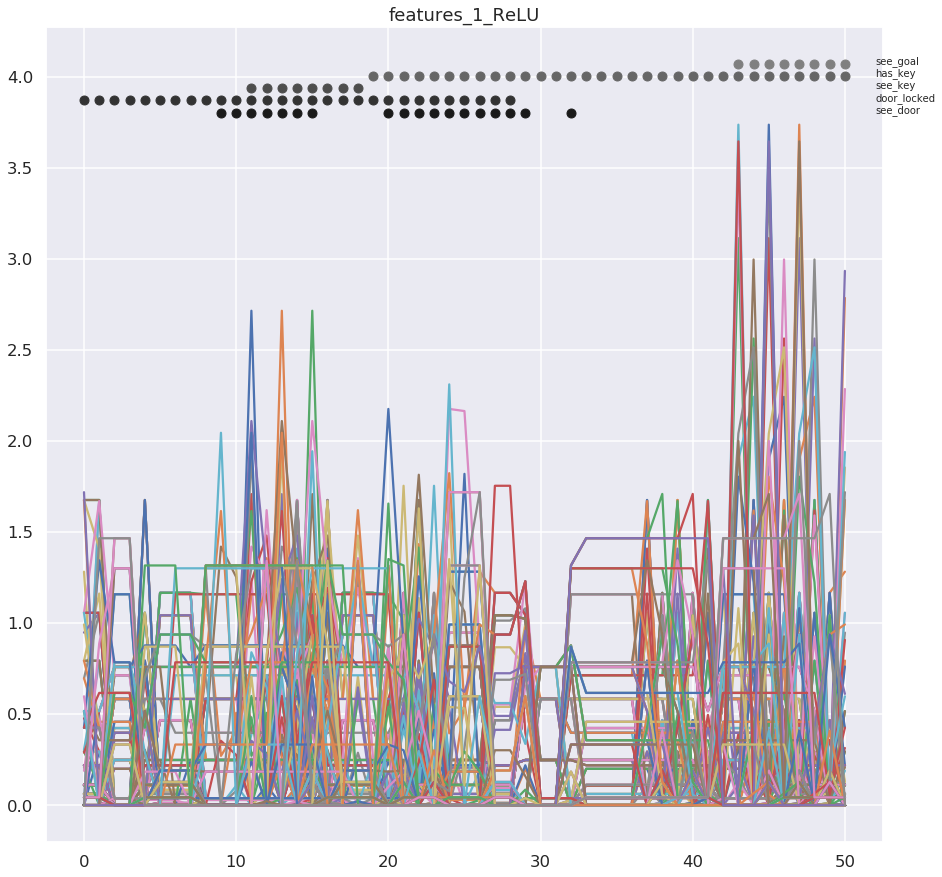

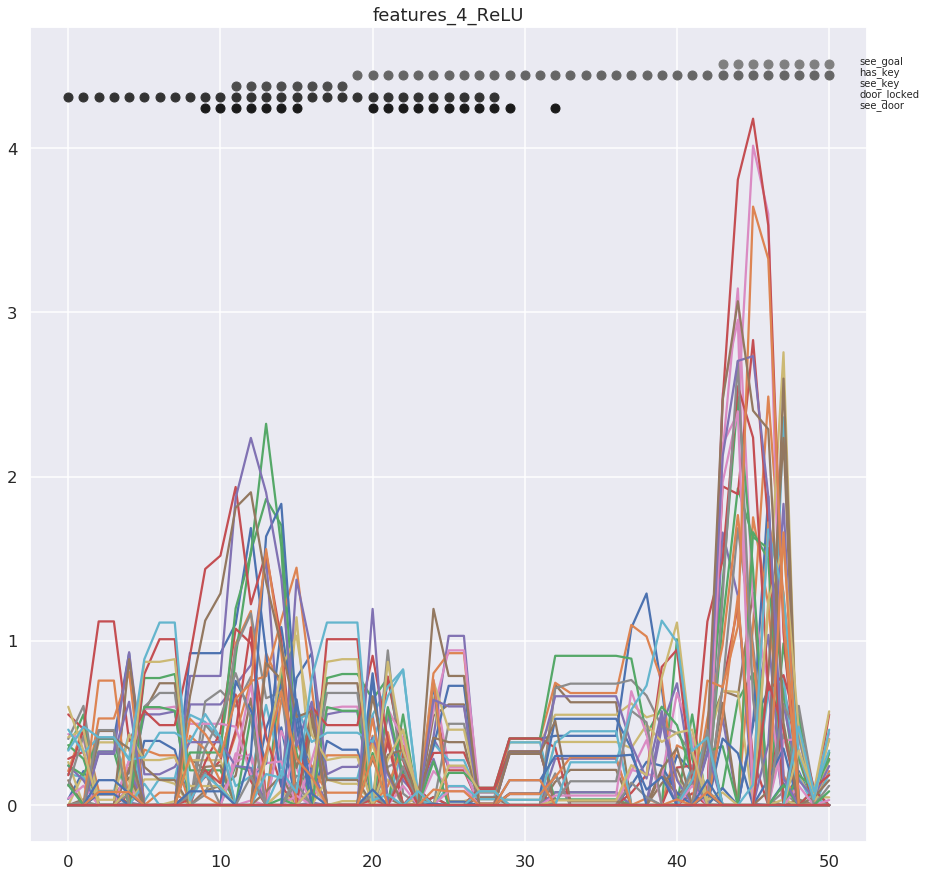

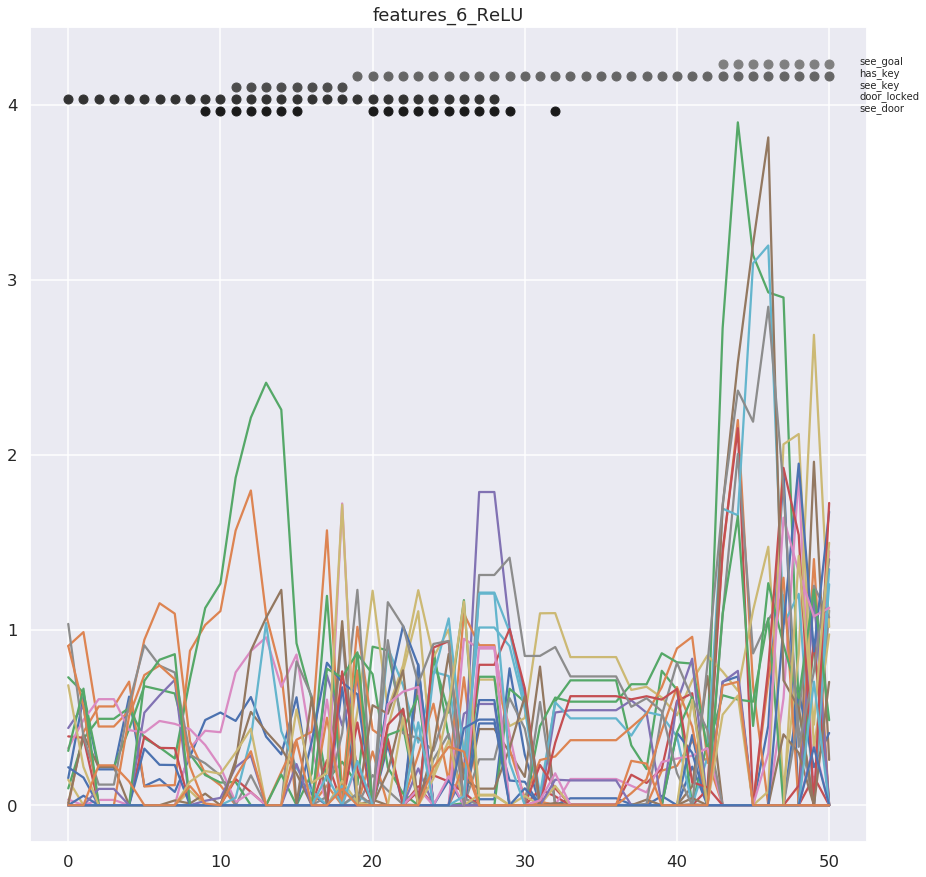

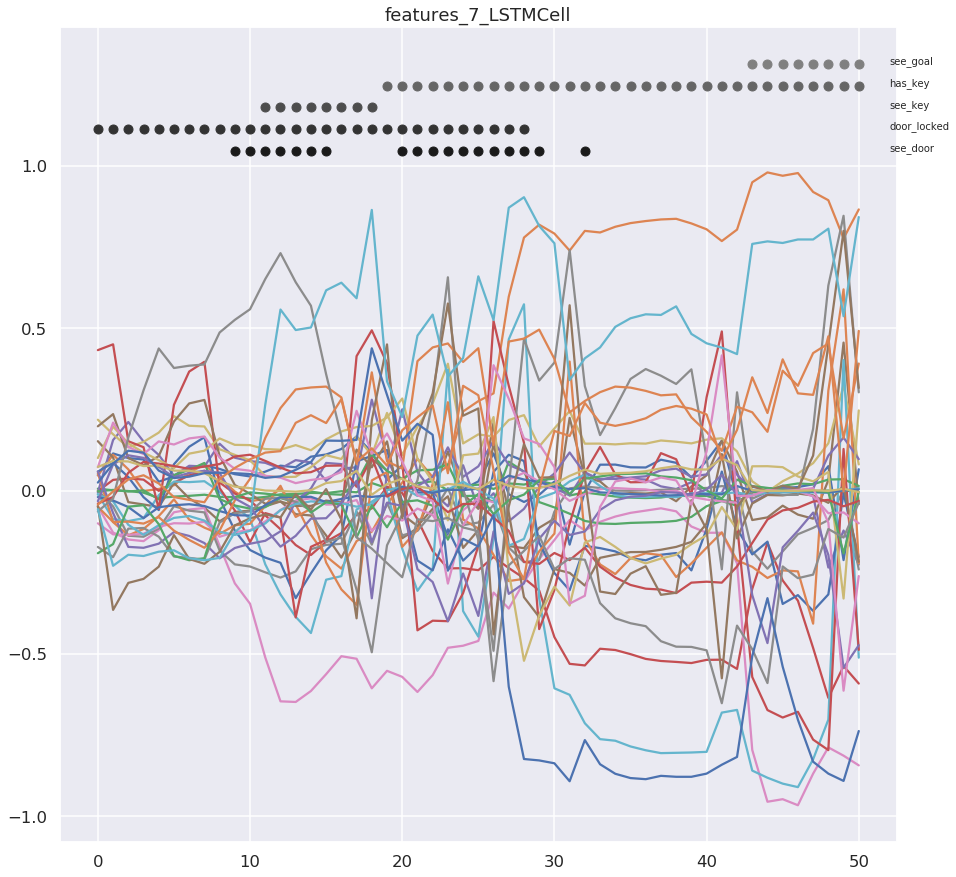

In [14]:
# select relu after each conv and LSTM
for i in [1,4,6,7]:
    fig, ax = plt.subplots(figsize=[15,15])
    activations = feature_data[i][:,::2]
    plt.plot(np.arange(len(feature_data[i])), activations)
    for j, key in enumerate(annotation_data.keys()):
        if 'Unnamed' in key:
            pass
        else:
            # scaling / placement of annotations
            m = 15
            k = (j+m)/m + np.max(activations)-1
            
            # get annotations from model observations / environment states
            x,y = get_annotations(annotation_data, i, k, key)
            plt.plot(x, y, linestyle='none', marker='o', color=(j/10,j/10,j/10))
            plt.text(len(feature_data[i])+1, k, key)
            
    plt.title(feature_names[i])
    plt.show()

Looking directly at the activations, we can see a number of things by eye. For instance, the convolutional layers have a strong tuning for detecting the key and goal, as indicated by the increased activiting when the key and goal come in to view. The LSTM traces are also very interesting, as they appear to by highly correlated in their transitions, for instance at time points when the model sees the key or opens the door, which should be time points when the overall goal state changes. At other times, we see stretches of very little change in activity. How do we make sense of all of this structure?

## Decoding Experiments
Next I replicate a classic approach in neuroscience, were a linear classification model is trained to read out information from the representations of various network layers. Here, I train an SVM to predict whether or not the agent is able to see the key, the door, or the goal, as well as whether or not the door is unlocked, or what the current intermediate goal of the agent is -- for instance, if the door is locked and the agent does not have the key, the agent should be seeking the key.

In these experiments, a single linear kernel SVM is trained per layer to detect the presence of each variable. scores reported are for the held out test data.

In [15]:
# compile all data!
root = 'feature_dir/DoorKey/'
DIRS = [os.path.join(root,DIR) for DIR in os.listdir(root)]

for i, DIR in enumerate(DIRS):
    if i == 0:
        feature_names, feature_data, obss_data, annotation_data = format_data(DIR)
    else:
        feature_names_i, feature_data_i, obss_data_i, annotation_data_i = format_data(DIR)
        assert(np.all([f==i for (f,i) in zip (feature_names,feature_names_i)]))
        for j in range(len(feature_data)):
            feature_data[j] = np.concatenate([feature_data[j],feature_data_i[j]])
        obss_data = np.concatenate([obss_data, obss_data_i])
        annotation_data = annotation_data.append(annotation_data_i)

# for convenience we'll just call the inputs a feature
feature_data.append(obss_data)
feature_names.append('obss_-1')

# compute goal state
annotation_data['goal'] = (annotation_data['has_key'].astype(int) + (annotation_data['door_locked']==False).astype(int)).values

In [16]:
from sklearn import svm
from sklearn.model_selection import train_test_split

scores = []
for i, feature_name in enumerate(feature_names):
    for key in annotation_data.keys():
        if 'Unnamed' in key:
            pass
        else:
            X = feature_data[i]
            y = np.array(annotation_data[key].values).astype(int)

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

            SVM = svm.SVC(kernel='linear')

            SVM.fit(X_train,y_train)
            score = SVM.score(X_test,y_test)
            scores.append([feature_name, key, score])
            
scores_frame = pd.DataFrame(columns=['feature_name', 'key', 'score'], data=scores)
scores_frame['order'] = scores_frame['feature_name'].apply(lambda name : int(name.split('_')[1])+1 )
scores_frame = scores_frame.sort_values(by=['order'])

Text(0.5, 1.0, 'Image through LSTM linear information content')

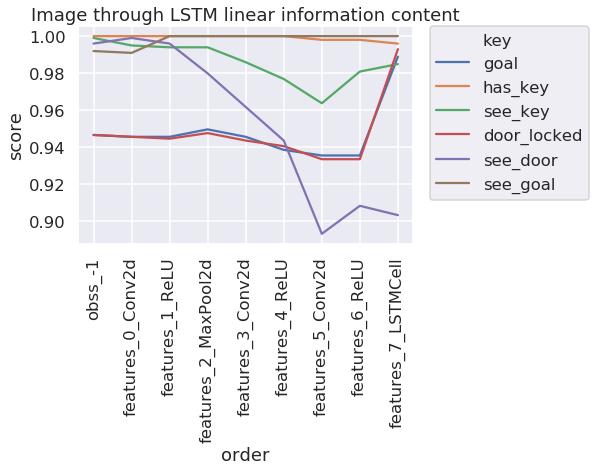

In [18]:
frame = scores_frame[scores_frame['order']<9]
labels = frame['feature_name'].unique()
ax = sns.lineplot(x='order', y='score', hue='key', data=frame)
ax.set_xticks(ticks=range(len(labels)))
ax.set_xticklabels(labels,rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Image through LSTM linear information content')

As seen in the plot above, decoding accuracy for all variables was quite high. This is interesting because it indicates that the variables investigated are linearly decodable from the network representations. The decoding accuracy for the `door_locked` and `goal` variables accross the hierarchy of layers are interesting, because they indicate that the LSTM is in fact keeping track of some high level environment / goal state.

## PCA Analysis
Next, I use principal components analysis to investigate the representations in the LSTM across all trials.

In [20]:
from sklearn.decomposition import PCA

def get_EV(dataset):
    data = dataset.reshape(-1,dataset.shape[-1])
    pca = PCA()
    pca.fit(data)

    return pca.explained_variance_ratio_

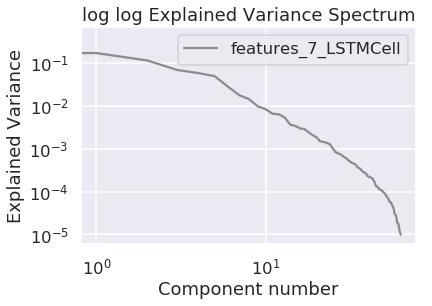

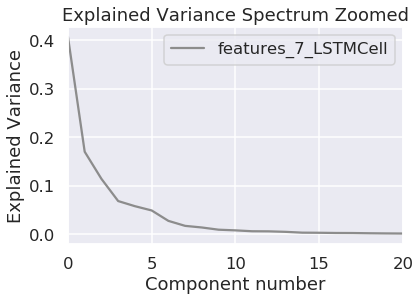

In [45]:
EVs = []
titles = []
for i, (feature_name, feature_datum) in enumerate(zip(feature_names, feature_data)):
    if feature_name in ['features_7_LSTMCell']:
        EV = get_EV(feature_datum)
#         EV = EV/np.max(EV)
        EV_frame = pd.DataFrame(columns=[feature_name],data=EV)
        ax = sns.lineplot(data=EV_frame, palette=[sns.color_palette()[i]])
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('log log Explained Variance Spectrum')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Component number')
        plt.show()
        ax = sns.lineplot(data=EV_frame, palette=[sns.color_palette()[i]])
        ax.set_xlim([0,20])
        ax.set_title('Explained Variance Spectrum Zoomed')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Component number')
        plt.show()

In [46]:
.4+.17+.1

0.67

This analysis shows that the representations contained in the LSTM are relatively high rank. The first three principal components contain less than 70% of the explained variance, and a large number of components have non zero explained variance. Still, we can look to see if visualizing the first two PCs explain anything about the agent's behaviour.

In [29]:
cmap = {
    0 : 'g',
    1 : 'y',
    2 : 'r'
}

gmap = {
    0 : 'Retreive Key',
    1 : 'Unlock Door',
    2 : 'Find Goal'
}

x = feature_data[7]
n = 3
pcs = ['pc'+str(i) for i in range(n)]
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns=pcs)

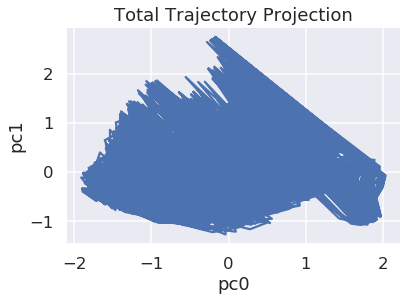

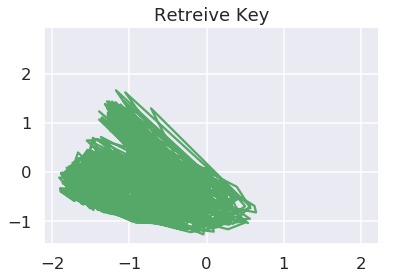

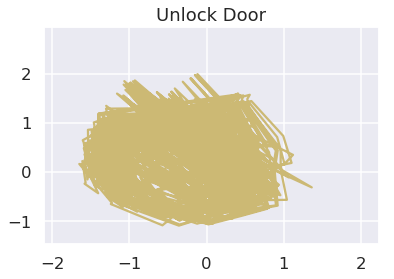

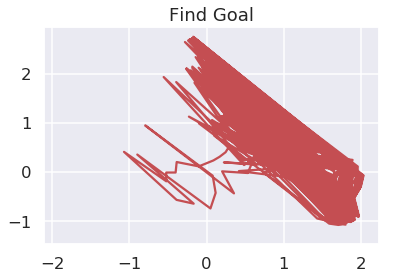

In [31]:
# outline linear projection of manifold
ax = sns.lineplot(x='pc0', y='pc1', sort=False, data=principalDf)
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.set_title('Total Trajectory Projection')
plt.show()

# project a single trace annotated by goal states onto manifold
all_trial_traj = principalDf.values[:]
all_trial_state = annotation_data['goal'].values[:]
for goal in range(0,3):
    goal_traj = all_trial_traj[all_trial_state==goal]
    ax = sns.lineplot(goal_traj[:,0],goal_traj[:,1], sort=False, color=cmap[goal])
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_title(gmap[goal])
    plt.show()

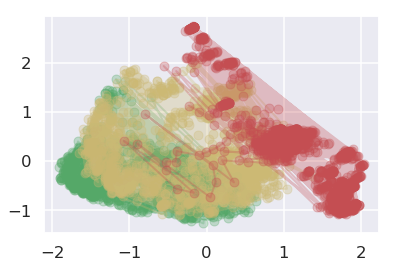

In [34]:
# project a single trace annotated by goal states onto manifold
all_trial_traj = principalDf.values[:]
all_trial_state = annotation_data['goal'].values[:]
for goal in range(0,3):
    goal_traj = all_trial_traj[all_trial_state==goal]
    ax = plt.plot(goal_traj[:,0],goal_traj[:,1], marker='o', color=cmap[goal], linewidth=2, alpha=0.3)

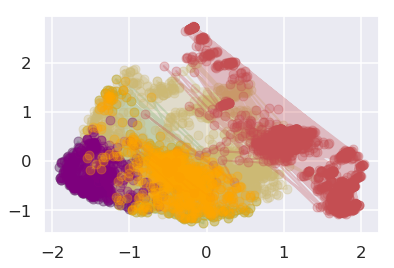

In [36]:
# lets add finer grain resolution; Purple is before seeing the key, Orange is after seeing the key
all_trial_traj = principalDf.values[:]
all_trial_state = annotation_data['goal'].values[:]
for goal in range(0,3):
    goal_traj = all_trial_traj[all_trial_state==goal]
    ax = plt.plot(goal_traj[:,0],goal_traj[:,1], marker='o', color=cmap[goal], linewidth=2, alpha=0.3)
    
    
see_key = all_trial_traj[(annotation_data['see_key'].values)&(annotation_data['door_locked'].values)]
dont_see_key = all_trial_traj[np.invert(annotation_data['see_key'].values)&(annotation_data['goal'].values==0)]

ax = plt.plot(dont_see_key[:,0], dont_see_key[:,1], c='purple', linestyle='none', marker='o', alpha=0.3)
ax = plt.plot(see_key[:,0], see_key[:,1], c='orange', linestyle='none', marker='o', alpha=0.3)

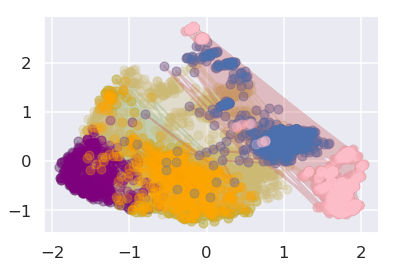

In [41]:
# add blue for before seeing the goal, and pink for after seeing the goal
all_trial_traj = principalDf.values[:]
all_trial_state = annotation_data['goal'].values[:]
for goal in range(0,3):
    goal_traj = all_trial_traj[all_trial_state==goal]
    ax = plt.plot(goal_traj[:,0],goal_traj[:,1], marker='o', color=cmap[goal], linewidth=2, alpha=0.3)
    

see_key = all_trial_traj[(annotation_data['see_key'].values)&(annotation_data['door_locked'].values)]
dont_see_key = all_trial_traj[np.invert(annotation_data['see_key'].values)&(annotation_data['goal'].values==0)]

see_goal = all_trial_traj[annotation_data['see_goal'].values]
dont_see_goal = all_trial_traj[np.invert(annotation_data['see_goal'].values)&np.invert(annotation_data['door_locked'].values)]

ax = plt.plot(dont_see_key[:,0], dont_see_key[:,1], c='purple', linestyle='none', marker='o', alpha=0.3)
ax = plt.plot(see_key[:,0], see_key[:,1], c='orange', linestyle='none', marker='o', alpha=0.3)

ax = plt.plot(dont_see_goal[:,0], dont_see_goal[:,1], c='b', linestyle='none', marker='o', alpha=0.3)
ax = plt.plot(see_goal[:,0], see_goal[:,1], c='pink', linestyle='none', marker='o', alpha=0.3)

In the above projection, purple corresponds to states before seeing the key, orange is after seeing the key. Yellow is before openning the door. Blue is after the door is open, but before seeing the goal, and pink is after seeing the goal. In conclusion, there seems to be a surprisingly large amount of the task state explained in the first two principal components.

## Recurrent Switching Linear Dynamical System Modelling
Finally, I try fitting a recurrent switching linear dynamical system (rSLDS) to model the data. Briefly, the rSLDS assumes that the data consists of K discrete states, where each state is governed by a linear dynamical system of latent factors. Graphically, this model can be described as: 
![Recurrent Switching Linear Dynamical System](img/rslds.png)

In [42]:
import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
from ssm.util import random_rotation

Initializing with an ARHMM using 50 steps of EM.


/home/joeldapello/Code/ssm/ssm/optimizers.py:131: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with message:\n{}".format(method, result.message))
/home/joeldapello/Code/ssm/ssm/optimizers.py:131: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with message:\n{}".format(method, result.message))
/home/joeldapello/Code/ssm/ssm/optimizers.py:131: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with message:\n{}".format(method, result.message))
/home/joeldapello/Code/ssm/ssm/optimizers.py:131: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with message:\n{}".format(method, result.message))
/home/joeldapello/Code/ssm/ssm/optimizers.py:131: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with m

No handles with labels found to put in legend.


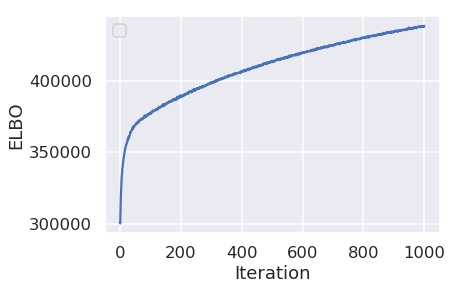

In [44]:
lstm = feature_data[7]

# model parameters
T = lstm.shape[0]
K = 8
D_obs = lstm.shape[-1]
D_latent = 10

# Fit a robust rSLDS with its default initialization
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent",
#              dynamics="gaussian",
#              emissions="gaussian",
             single_subspace=True)

rslds.initialize(lstm,num_em_iters=50)

# Uncomment this to fit with stochastic variational inference instead
q_svi = SLDSTriDiagVariationalPosterior(rslds, lstm)
elbos = rslds.fit(q_svi, lstm, method="svi", num_iters=1000, initialize=False)
xhat = q_svi.mean[0]
zhat = rslds.most_likely_states(xhat, lstm)

# Plot some results
plt.figure()
plt.plot(elbos)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

In [48]:
# slight patch to `get_annotations`
def get_annotations(annotation_data, i, j, key):
    x = np.arange(i)
    y = annotation_data[key].values.astype(int)*(j)
    xy = np.array([[x,y] for (x,y) in zip(x,y) if y!=0])
    return xy[:,0], xy[:,1]

In [50]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

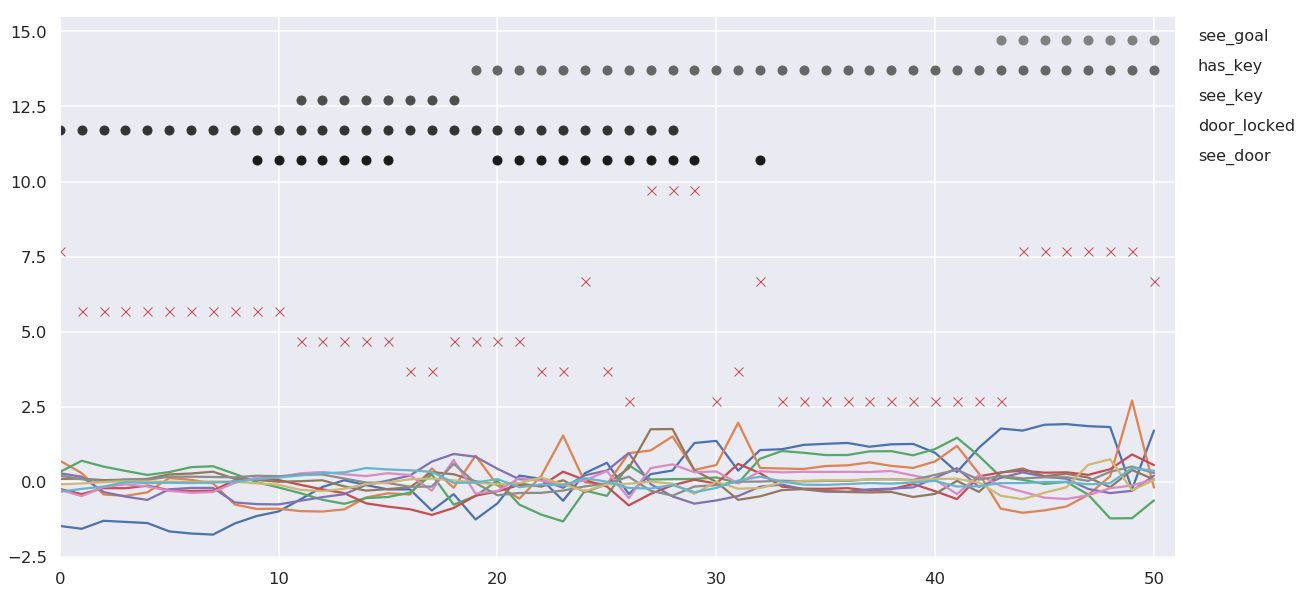

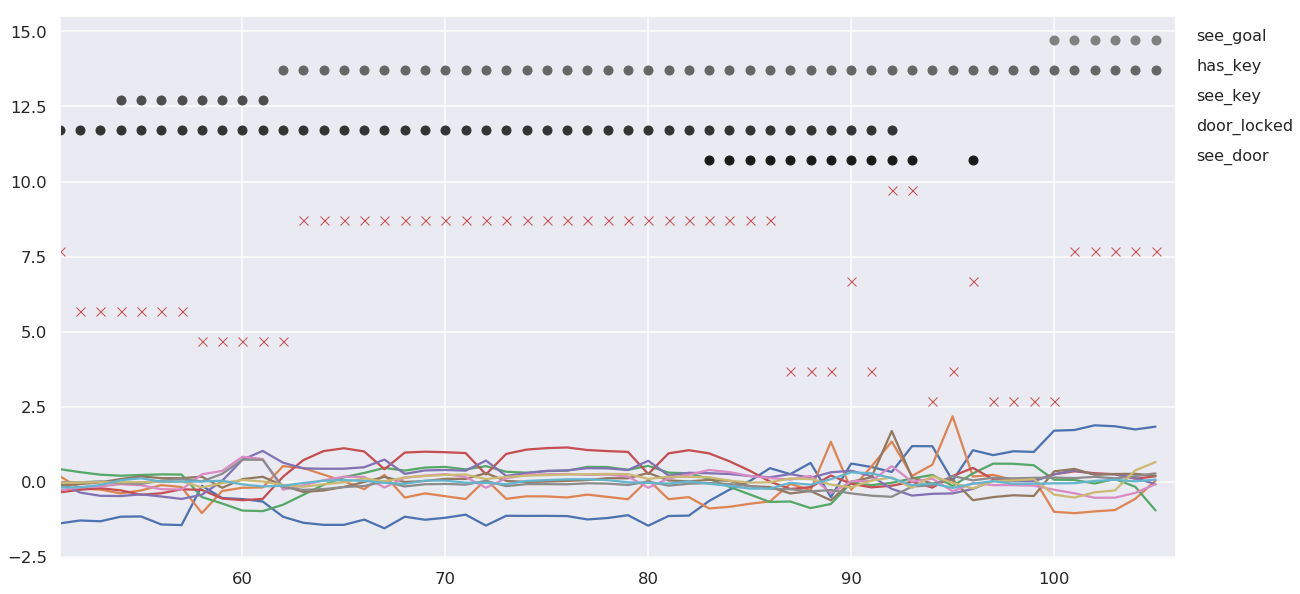

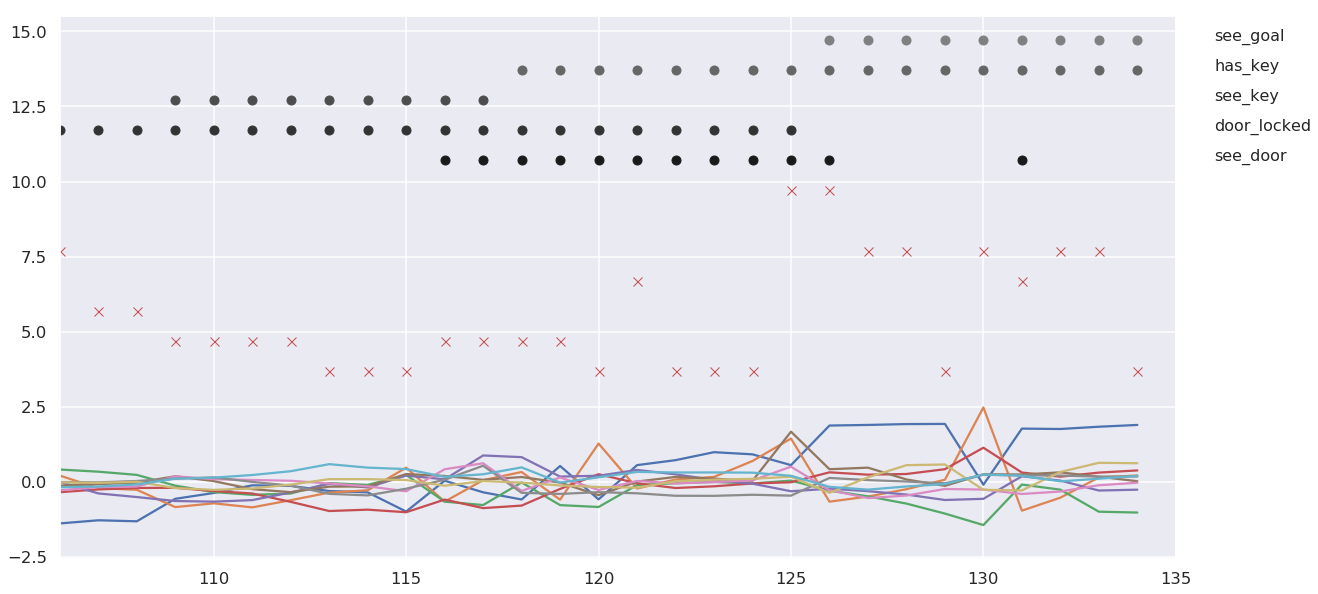

In [57]:
for start, end in [[0,51],[51,106],[106,135]]:
    plt.plot(xhat[:end])
    z_plot = zhat[:end] + np.max(xhat[:end])
    plt.plot(z_plot, linestyle='none', marker='x', c='r')
    for j, key in enumerate(annotation_data.keys()):
        if ('Unnamed' in key) or ('DIR' in key):
            pass
        else:
            k = (j+0)
            if k < 6:
                x,y = get_annotations(annotation_data, end, k, key)
                y = y.astype('float')
                y += np.max(z_plot).astype('float')
                plt.plot(x, y, linestyle='none', marker='o', color=(j/10,j/10,j/10))
                plt.text((end)+1, y[0], key, fontsize=16)
    plt.xlim([start,end])
    plt.show()

An rSLDS with 8 discrete states and 10 dimensional latent factor models was fitted to all trials using stochastic variational inference. The above three plots show the inferred states and continuous latent dynamics for three separate trials. By inspection we can see that a number of intuitive high level states were captured by the model -- for instance the agent usually starts in the same state, and transitions to the same subsequent state upon seeing the key. Additionally, the same state is recovered each time the agent is interacting with the door (when `door_locked` transtions) and the same state is often recovered during the home stretch which the agent is approaching the goal. However, we can see that a number of extraneous state switches happen -- for instance, if the agent sees the door again while searching for the goal, there is often a brief switch to a particular state. Additionally, it seems that turns (not visualized) are often associated with state switches. 

There are many possible explanations for the extraneous state switches recovered by the rSLDS. Of course there is the trivial but non-negligible possibility that the rSLDS model was just not optimized to fit very well. There is also the possibility that the activations are all together too nonlinear to be modeled by even a collection of linear dynamical systems. More interestingly, one possibility is that the LSTM has learned some hierarchical structuring, where in the network is keeping track of a hierarchy of states, which do not necessarily transition at the same time. 

Going forward, it would interesting to search for such a hierarchical structure, which could manifest as some set of cells being responsible for keeping track of goals, while another set of cells processed and routed input information, and / or another set of cells coordinated navigation.